In [2]:
# Import necessary packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

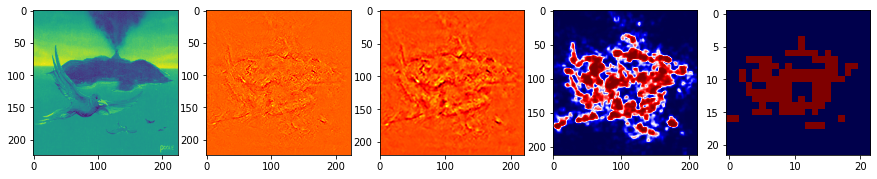

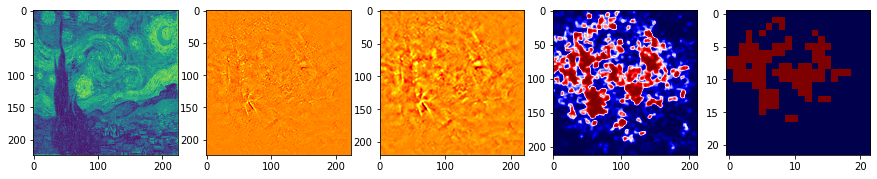

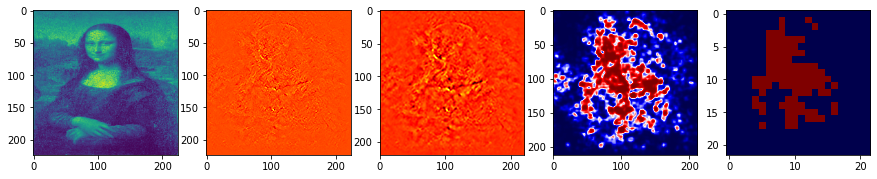

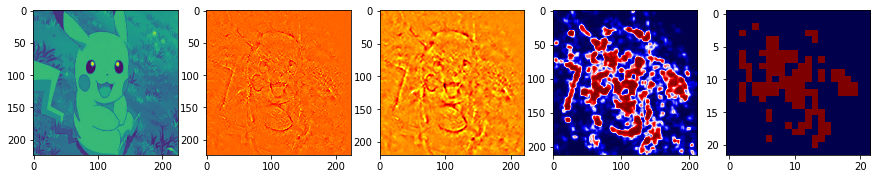

In [4]:
def input_img(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def normalize_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def convolution(img, kernel):
    # img has shape (x, y), already normalized
    # kernel has shape (3, 3)
    # output has shape (x-2, y-2)
    x = img.shape[0]
    y = img.shape[1]
    output = np.zeros((x-2, y-2))
    for i in range(1, x-1):
        for j in range(1, y-1):
            output[i-1, j-1] = np.sum(img[i-1:i+2, j-1:j+2] * kernel)
    return output

def blur(img):
    # img has shape (x, y), already normalized
    
    # gaussian filter
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    img = convolution(img, kernel)
    img = convolution(img, kernel)

    # normalize
    img = (img - np.min(img))/ (np.max(img)- np.min(img))

    return img

def turbulence(img):
    # img has shape (x, y), already normalized
    # kernel has shape (5, 5)
    # output has shape (x-2, y-2)
    x = img.shape[0]
    y = img.shape[1]
    output = np.zeros((x-4, y-4))
    for i in range(2, x-2):
        for j in range(2, y-2):
            output[i-2, j-2] = np.max(img[i-2:i+3, j-2:j+3]) - np.min(img[i-2:i+3, j-2:j+3])
    return output

def quinticBezier(x):
    return 6*x**5 - 15*x**4 + 10*x**3

def polarize(img):
    # img has shape (x, y)

    img = turbulence(img)

    # mean
    mean = np.mean(img)
    stddev = np.std(img)

    # mean should be 0.5, stddev should be 0.1
    img = (img - mean) / stddev
    img = 1 / (1 + np.exp(-img))

    img = blur(img)

    img = (img - np.min(img))/ (np.max(img)- np.min(img))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i, j] = quinticBezier(img[i, j])

    return img
    
def segment(img):
    resolution_ratio = 0.1
    cutoff = .5

    # img has shape (x, y)
    # output has shape (Math.ceil(x*resolution_ratio), Math.ceil(y*resolution_ratio))

    x = img.shape[0]
    y = img.shape[1]

    output = np.zeros((int(np.ceil(x*resolution_ratio)), int(np.ceil(y*resolution_ratio))))

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = np.mean(img[int(i/resolution_ratio):int((i+1)/resolution_ratio), int(j/resolution_ratio):int((j+1)/resolution_ratio)])
            

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output[i, j] < cutoff:
                output[i, j] = 0
            else:
                output[i, j] = 1

    return output

def plot_images(img1, img2, img3, img4, img5):
    fig, axs = plt.subplots(1, 5, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[1].imshow(img2, cmap = "hot")
    axs[2].imshow(img3, cmap = "hot")
    axs[3].imshow(img4, cmap = "seismic")
    axs[4].imshow(img5, cmap = "seismic")
    plt.show()

def show_saliency(image_url, test_model):
    filename = 'image.jpg'
    urllib.request.urlretrieve(image_url, filename)
    img = input_img(filename)
    img = tf.keras.applications.densenet.preprocess_input(img)

    result = test_model(img)
    max_idx = tf.argmax(result, axis = 1)

    with tf.GradientTape() as tape:
        tape.watch(img)
        result = test_model(img)
        max_score = result[0, max_idx[0]]
    grads = tape.gradient(max_score, img)
    plot_images(normalize_image(img[0]), normalize_image(grads[0]), blur(normalize_image(grads[0])), polarize(blur(normalize_image(grads[0]))), segment(polarize(blur(normalize_image(grads[0])))))

test_model = tf.keras.applications.resnet50.ResNet50()

images = [
    'https://cards.scryfall.io/art_crop/front/4/9/496849a5-4b24-4eae-8bfb-d46f645d85ea.jpg?1675200313',
    'https://www.vangoghgallery.com/img/starry_night_full.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1200px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg',
    'https://d.newsweek.com/en/full/822411/pikachu-640x360-pokemon-anime.jpg?w=1600&h=1200&q=88&f=3ed1c0d6e3890cbc58be90f05908a8f5'
]

for image in images:
    show_saliency(image, test_model)
